In [1]:
from itertools import cycle

from scipy.interpolate import lagrange, make_interp_spline
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
from math import factorial

In [2]:
%matplotlib inline
plt.style.use("seaborn")
plt.rc('figure', figsize=(20, 10))

# Task 1

In [3]:
x = np.array([0.132, 0.567, 1.153, 
              2.414, 3.939])
y = np.array([69.531, 1.112, -1.672, 
              -1.922, -1.925])

## Linear, quadratic spline and Lagrange polynomial

### Lagrange polynomial

In [4]:
lagrange_poly = lagrange(x, y)
print(lagrange_poly)

       4         3         2
16.73 x - 135.7 x + 358.2 x - 355.4 x + 110.5


### Linear spline

In [5]:
lspline = make_interp_spline(x, y, 1)

### Quadratic spline

In [6]:
def quadratic_spline(X, y):
    """Return the function which 
    computes the values of the quadratic splines
    """
    from bisect import bisect_left
    from collections import Collection
    
    n = len(X)
    h = np.diff(X)
    a = np.array(y)
    # By customizing this initial parameter, you adjust the convexity of the resulting splines
    b = [1.8 * (y[1]-y[0]) / h[0]] 
    c = []
    
    splines = []
    for i in range(n - 1):
        z = 2 * (a[i + 1]-a[i]) / h[i]
        b.append(z - b[i])
        c.append((b[i + 1]-b[i]) / (2*h[i]))
        
        splines.append(
            np.poly1d([
                c[i],
                b[i] - 2*c[i]*X[i],
                a[i] - b[i]*X[i] + c[i]*X[i]**2
            ]))
        
    def result(x):   
        """Return the value of the quadratic splines at the point x"""
        if isinstance(x, Collection) and not isinstance(x, str):
            return np.array([result(xi) for xi in x])
        elif isinstance(x, float):            
            index = 0 if x == X[0] else bisect_left(X, x)-1
            return splines[index](x)
        else:
            raise ValueError("Value must be array-like or float")
    
    result.splines = splines
    return result

#### Parabolas

In [7]:
qspline = quadratic_spline(x, y)
for qspl in qspline.splines:
    print(qspl)

       2
289.3 x - 359.5 x + 111.9
       2
45.57 x - 83.14 x + 33.6
        2
-17.57 x + 62.47 x - 50.34
       2
14.66 x - 93.11 x + 137.4


## Graph

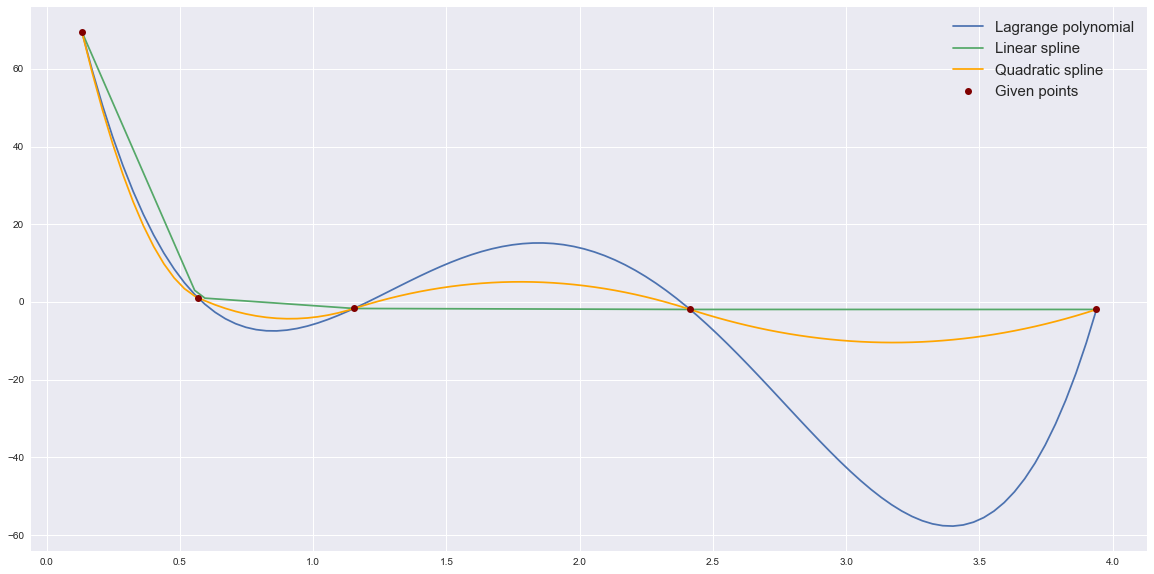

In [8]:
X = np.linspace(x[0], x[-1], 100)

plt.plot(X, lagrange_poly(X), label="Lagrange polynomial")
plt.plot(X, lspline(X), label="Linear spline")
plt.plot(X, qspline(X), c='orange', label="Quadratic spline")
plt.plot(x, y, 'o', c='maroon', label="Given points")
    
plt.legend(fontsize=15)

plt.show()

## Values of the functions at the $(x_0+x_1)$ point

In [9]:
funcs = [("Lagrange polynomial", lagrange_poly), 
         ("Linear spline", lspline), 
         ("Quadratic spline", qspline)]
x01 = x[0] + x[1]
print(f"Value of the functions in the x={x01}:\n")
for name, func in funcs:
    print(f"{name}: {func(x01)}")

Value of the functions in the x=0.699:

Lagrange polynomial: -5.305620605614237
Linear spline: 0.4848873720136521
Quadratic spline: -2.246250258910898


# Task 2
## Function
### $y = \sin^3(x) + \cos(x) - \lg|ct|$
#### $c = t^2 + \sqrt{a}\\t=-3\\a=8.8$

In [10]:
def f(x):
    t = -3
    a = 8.8
    c = t**2 + np.sqrt(a)
    return np.sin(x)**3 + np.cos(x) - np.log10(np.abs(c*t))

### Values of the given function at the points $x_i=x_0+ih, i=\overline{0, 5}$
### ($x_i,f(x_i)$)

In [11]:
x0 = 1
h = 0.1
x1 = np.linspace(x0, 1.5, 6)
y1 = np.array(f(x1))
tuple(zip(x1, y1))

((1.0, -0.41896210959347813),
 (1.1000000000000001, -0.39364958704510733),
 (1.2, -0.38307047227676705),
 (1.3, -0.39297864456909792),
 (1.3999999999999999, -0.42813926855759044),
 (1.5, -0.49184668101555529))

## Table of the finite differences

In [12]:
def get_diffs(x):
    """Return the table of the finite differences"""
    x = np.array(x)
    diffs = [x]
    for i in range(len(x) - 1):
        x = np.diff(x)
        diffs.append(x)
    return np.array(diffs)

In [13]:
for d in get_diffs(y1): 
    print(d)

[-0.41896211 -0.39364959 -0.38307047 -0.39297864 -0.42813927 -0.49184668]
[ 0.02531252  0.01057911 -0.00990817 -0.03516062 -0.06370741]
[-0.01473341 -0.02048729 -0.02525245 -0.02854679]
[-0.00575388 -0.00476516 -0.00329434]
[ 0.00098871  0.00147083]
[ 0.00048211]


## The Newton interpolation polynomial

In [15]:
def get_newton_poly_coeffs(x, y, h):
    """Return the coefficients 
    of the Newton interpolation polynomial
    """
    diffs = get_diffs(y)  
    a = [diffs[i][0] / (factorial(i)*h**i) for i in range(len(x))]
    return a

### Coefficients

In [16]:
get_newton_poly_coeffs(x1, y1, h)

[-0.41896210959347813,
 0.25312522548370797,
 -0.73667038900152571,
 -0.95897988010677293,
 0.41196443547923212,
 0.40176101419135218]

In [17]:
def get_newton_poly(X, y, h):
    """Return the function of the Newton interpolation polynomial"""
    from collections import Collection
    
    a = get_newton_poly_coeffs(X, y, h)
    
    def result(x):
        """Return the value of the Newton polynomial at the point x"""
        if isinstance(x, Collection) and not isinstance(x, str):
            return np.array([result(x_) for x_ in x])
        elif isinstance(x, float):
            return np.sum([a_*np.prod([x - x_ for x_ in X[:i]]) for i, a_ in enumerate(a)])
        else:
            raise ValueError("Value must be array-like or float")        
    
    return result

### Graph

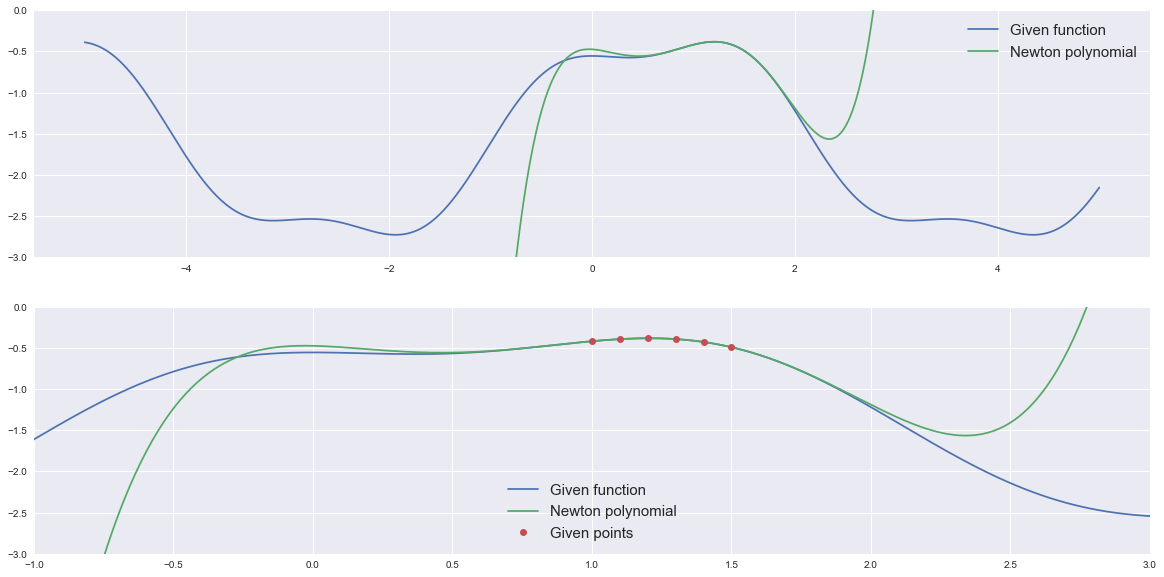

In [19]:
X = np.linspace(-5, 5, 1000)
newton_poly = get_newton_poly(x1, y1, h)

fig, axes = plt.subplots(2)

for ax in axes:
    ax.plot(X, f(X), label="Given function")
    ax.plot(X, newton_poly(X), label="Newton polynomial")

axes[-1].plot(x1, y1, 'o', label="Given points")

axes[0].set_ylim([-3, 0])
axes[1].set_xlim([-1, 3])
axes[1].set_ylim([-3, 0])

axes[0].legend(fontsize=15)
axes[1].legend(fontsize=15)

plt.show()

## Values of the polynomial and the given function at the point $(x_1+x_2)$

In [20]:
funcs = [("Newton polynomial", newton_poly), 
         ("Given function", f)]
x12 = x1[1] + x1[2]
print(f"Value of the functions in the x={x12}:\n")
for name, func in funcs:
    print(f"{name}: {func(x12)}")

Value of the functions in the x=2.3:

Newton polynomial: -1.5573039159707731
Given function: -1.8066947052969071


# Task 3

In [21]:
x2 = np.array([0.282, 0.614, 
               0.946, 1.278, 
               1.61, 1.942, 
               2.274, 2.606, 
               2.938])
y2 = np.array([6.234, 0.848, 
               -0.473, -0.938, 
               -1.062, -1.225, 
               -1.225, -1.433, 
               -1.285])

## Least squares method

In [22]:
def get_least_square(x, y, k):
    """Return the least square polynomial"""
    x = np.array(x)
    y = np.array(y)
    m = len(x)
    A = []
    y_sum = np.sum(y)
    B = np.array([np.sum(y * x**i) for i in range(k + 1)])
    for i in range(k + 1):
        A.append([np.sum(x ** (i+j)) for j in range(k + 1)])
    A = np.array(A)
    c = lin.solve(A, B)
    return np.poly1d(c.ravel()[::-1])

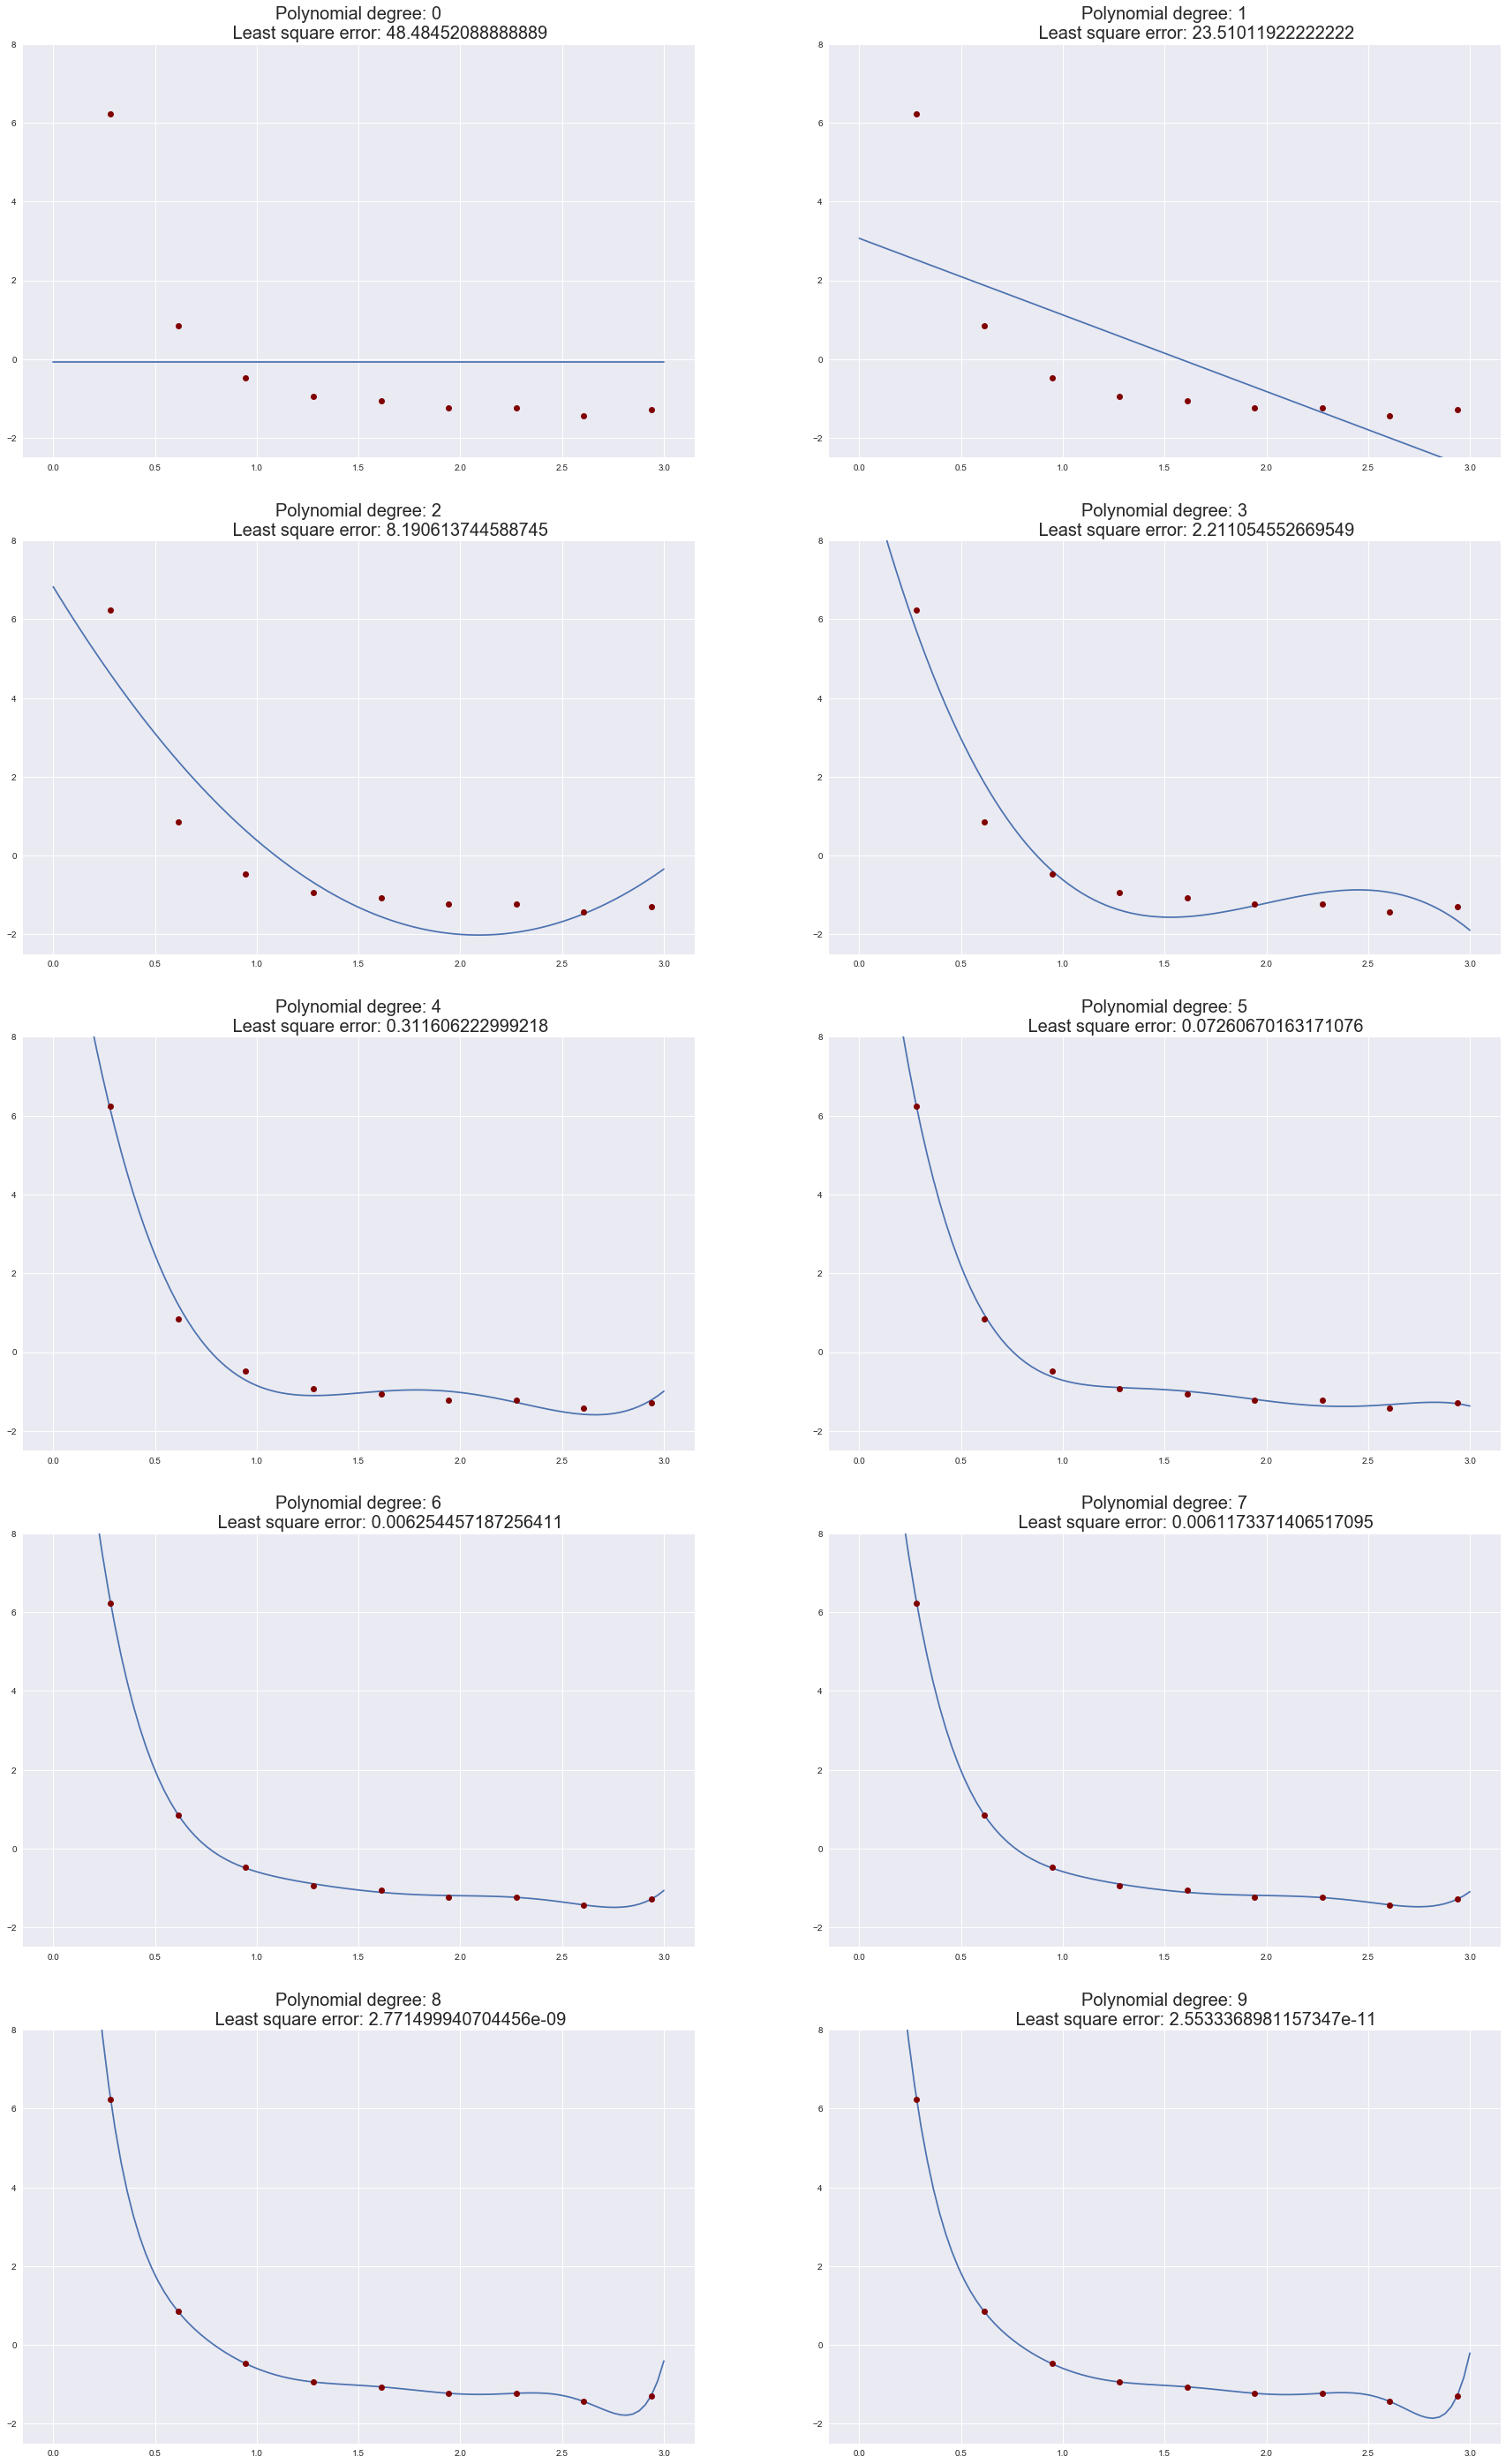

In [24]:
least_squares = ((i, get_least_square(x2, y2, i)) 
                 for i in range(len(x2) + 1)).__next__
X = np.linspace(0, 3, 100)

fig, axeses = plt.subplots(5, 2, figsize=(30, 50))

for axes in axeses:
    for ax in axes:
        i, ls = least_squares()
        ax.plot(X, ls(X))
        ax.plot(x2, y2, 'o', c="maroon")
        ax.set_ylim([-2.5, 8])
        ax.set_title(f"Polynomial degree: {i}\n \
            Least square error: {np.sum((y2 - ls(x2)) ** 2)}", fontsize=20)
plt.show()